In [19]:
import pandas as pd

# Load the CSV files
df60 = pd.read_csv("MSJO 60 01-03 2023.csv", delimiter=";")
df900 = pd.read_csv("MSJO 900 01-03 2023.csv", delimiter=";")

# Set PVALUE to float
df60["PVALUE"] = df60["PVALUE"].str.replace(",", ".").astype(float)
df900["PVALUE"] = df900["PVALUE"].str.replace(",", ".").astype(float)

# Duplicate deletion
df60.drop_duplicates(inplace=True)
df900.drop_duplicates(inplace=True)

# Delete rows with empty values
df60 = df60.dropna(subset=["MESS_ID", "VALUEDATE", "PVALUE"], how="any")
df900 = df900.dropna(subset=["MESS_ID", "VALUEDATE", "PVALUE"], how="any")

# Convert VALUEDATE to datetime
df60["VALUEDATE"] = pd.to_datetime(df60["VALUEDATE"])
df900["VALUEDATE"] = pd.to_datetime(df900["VALUEDATE"])

# Filter date range
df60 = df60[(df60['VALUEDATE'] > '2023-01-15') & (df60['VALUEDATE'] < '2023-03-20')]
df900 = df900[(df900['VALUEDATE'] > '2023-01-15') & (df900['VALUEDATE'] < '2023-03-20')]

# Define a function to filter outliers for each MESS_ID
def filter_outliers(df):
    # Group-wise calculation of quartiles and upper thresholds
    grouped = df.groupby("MESS_ID")
    filtered_dfs = []

    for name, group in grouped:
        # Calculate quartiles
        Q1 = group["PVALUE"].quantile(0.25)
        Q3 = group["PVALUE"].quantile(0.75)
        IQR = Q3 - Q1
        
        # Filter outliers
        filtered_group = group[(group["PVALUE"] >= Q1 - IQR) & (group["PVALUE"] <= Q3  + IQR)]
        
        # Check if there are filtered rows
        if not filtered_group.empty:
            # Append filtered group to list
            filtered_dfs.append(filtered_group)
    
    # Concatenate filtered dataframes if there are any
    if filtered_dfs:
        df_filtered = pd.concat(filtered_dfs)
        return df_filtered
    else:
        return None

# Filter outliers for df60 and df900 separately
df60_filtered = filter_outliers(df60)
df900_filtered = filter_outliers(df900)

if df60_filtered is not None:
    df60_filtered.sort_values(by=["MESS_ID", "VALUEDATE"], ascending=[True, True], inplace=True)

if df900_filtered is not None:
    df900_filtered.sort_values(by=["MESS_ID", "VALUEDATE"], ascending=[True, True], inplace=True)

# Save to CSV
if df60_filtered is not None:
    df60_filtered.to_csv("cleaned60.csv", index=False)

if df900_filtered is not None:
    df900_filtered.to_csv("cleaned900.csv", index=False)




In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

def preprocess_data(data, is_energy_data=False):
    if is_energy_data:
        if 'VALUEDATE' in data.columns:
            data['VALUEDATE'] = pd.to_datetime(data['VALUEDATE'])
            data['Year'] = data['VALUEDATE'].dt.year
            data['Month'] = data['VALUEDATE'].dt.month
            data['Day'] = data['VALUEDATE'].dt.day
            data['Hour'] = data['VALUEDATE'].dt.hour
            data['Minute'] = data['VALUEDATE'].dt.minute
            data.drop(columns=['VALUEDATE'], inplace=True)
    return data

def train_and_evaluate(energy_data_file, energy_id_col, sample_size=None):
    try:
        # Load the energy data
        print(f"Loading energy data from {energy_data_file}...")
        energy_data = pd.read_csv(energy_data_file)
        energy_data = preprocess_data(energy_data, is_energy_data=True)
        print("Energy data loaded.")

        # Sample the data if sample_size is specified
        if sample_size:
            energy_data = energy_data.sample(n=sample_size, random_state=42)
            print(f"Data sampled. Using {sample_size} rows of the data.")
        else:
            sample_size = len(energy_data)
            print(f"Using all {sample_size} rows of the data.")

        # Features for prediction
        features = ['MESS_ID', 'Year', 'Month', 'Day', 'Hour', 'Minute']
        X = energy_data[features]
        y = energy_data['PVALUE']

        # Training and evaluation using XGBoost
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model_xgb = XGBRegressor(random_state=42)
        print("Training model...")
        start_time = time.time()
        model_xgb.fit(X_train, y_train)
        print(f"Model trained in {time.time() - start_time} seconds.")
        y_pred_xgb = model_xgb.predict(X_test)
        mse_xgb = mean_squared_error(y_test, y_pred_xgb)
        print("Mean Squared Error (XGBoost):", mse_xgb)

        # Plotting results
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test, y_pred_xgb, color='blue')
        plt.plot(y_test, y_test, color='red')  # Diagonal line for reference
        plt.title('Energy Production and Consumption: Actual vs Predicted (XGBoost)')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()

    except Exception as e:
        print("An error occurred:", e)

# File paths for the two datasets
energy_data_minute = 'cleaned60.csv'
energy_data_15_minutes = 'cleaned900.csv'

# Column names to use for merging
energy_id_col = 'MESS_ID'

# Load the 15-minute-based dataset to determine sample size
print("Determining sample size from 15-minute-based dataset...")
fifteen_minute_data = pd.read_csv(energy_data_15_minutes)
fifteen_minute_data = preprocess_data(fifteen_minute_data, is_energy_data=True)
sample_size = len(fifteen_minute_data)
print(f"Sample size determined: {sample_size} rows.")

print("\nResults for energy produced and consumed every minute:")
train_and_evaluate(energy_data_minute, energy_id_col, sample_size=sample_size)  # Using the same sample size as the 15-minute-based data

print("\nResults for energy produced and consumed every 15 minutes:")
train_and_evaluate(energy_data_15_minutes, energy_id_col, sample_size=None)  # Using all of the 15-minute-based data



Determining sample size from 15-minute-based dataset...
Sample size determined: 342103 rows.

Results for energy produced and consumed every minute:
Loading energy data from cleaned60.csv...


Determining sample size from 15-minute-based dataset...
Sample size determined: 342103 rows.

Results for energy produced and consumed every minute:
Loading energy data from cleaned60.csv...
Energy data loaded.
Data sampled. Using 342103 rows of the data.
Training model...
Model trained in 2.4406166076660156 seconds.
Mean Squared Error (CatBoost): 96.60257703680989


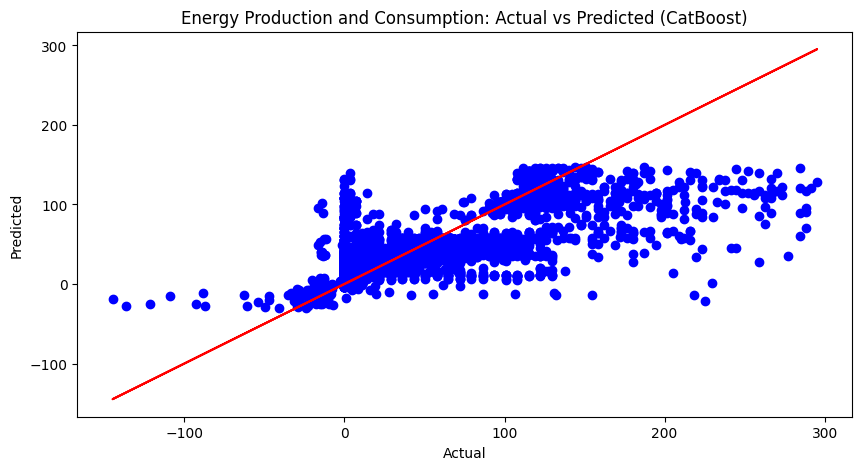


Results for energy produced and consumed every 15 minutes:
Loading energy data from cleaned900.csv...
Energy data loaded.
Using all 342103 rows of the data.
Training model...
Model trained in 2.3009321689605713 seconds.
Mean Squared Error (CatBoost): 8686.995871464202


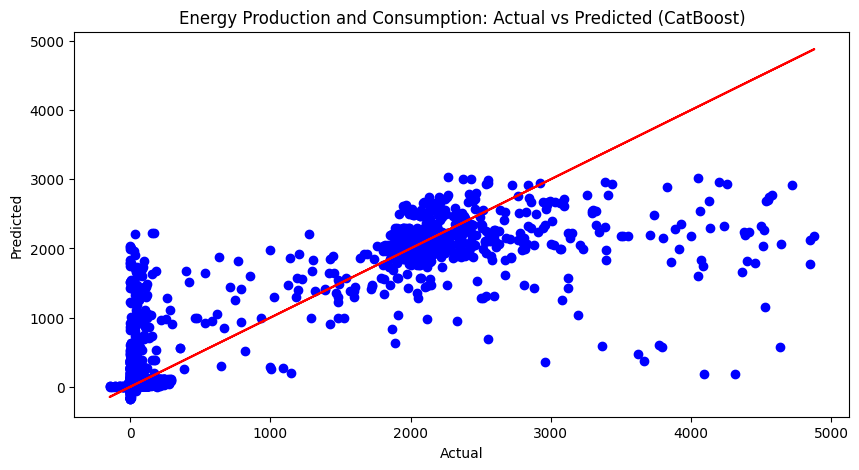

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler

def preprocess_data(data, is_energy_data=False):
    if is_energy_data:
        if 'VALUEDATE' in data.columns:
            data['VALUEDATE'] = pd.to_datetime(data['VALUEDATE'])
            data['Year'] = data['VALUEDATE'].dt.year
            data['Month'] = data['VALUEDATE'].dt.month
            data['Day'] = data['VALUEDATE'].dt.day
            data['Hour'] = data['VALUEDATE'].dt.hour
            data['Minute'] = data['VALUEDATE'].dt.minute
            data.drop(columns=['VALUEDATE'], inplace=True)
    return data

def train_and_evaluate(energy_data_file, energy_id_col, sample_size=None):
    try:
        # Load the energy data
        print(f"Loading energy data from {energy_data_file}...")
        energy_data = pd.read_csv(energy_data_file)
        energy_data = preprocess_data(energy_data, is_energy_data=True)
        print("Energy data loaded.")

        # Sample the data if sample_size is specified
        if sample_size:
            energy_data = energy_data.sample(n=sample_size, random_state=42)
            print(f"Data sampled. Using {sample_size} rows of the data.")
        else:
            sample_size = len(energy_data)
            print(f"Using all {sample_size} rows of the data.")

        # Features for prediction
        features = ['MESS_ID', 'Year', 'Month', 'Day', 'Hour', 'Minute']
        X = energy_data[features]
        y = energy_data['PVALUE']

        # Training and evaluation using CatBoost
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model_cb = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_state=42, verbose=0)
        print("Training model...")
        start_time = time.time()
        model_cb.fit(X_train, y_train)
        print(f"Model trained in {time.time() - start_time} seconds.")
        y_pred_cb = model_cb.predict(X_test)
        mse_cb = mean_squared_error(y_test, y_pred_cb)
        print("Mean Squared Error (CatBoost):", mse_cb)

        # Plotting results
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test, y_pred_cb, color='blue')
        plt.plot(y_test, y_test, color='red')  # Diagonal line for reference
        plt.title('Energy Production and Consumption: Actual vs Predicted (CatBoost)')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()

    except Exception as e:
        print("An error occurred:", e)

# File paths for the two datasets
energy_data_minute = 'cleaned60.csv'
energy_data_15_minutes = 'cleaned900.csv'

# Column names to use for merging
energy_id_col = 'MESS_ID'

# Load the 15-minute-based dataset to determine sample size
print("Determining sample size from 15-minute-based dataset...")
fifteen_minute_data = pd.read_csv(energy_data_15_minutes)
fifteen_minute_data = preprocess_data(fifteen_minute_data, is_energy_data=True)
sample_size = len(fifteen_minute_data)
print(f"Sample size determined: {sample_size} rows.")

print("\nResults for energy produced and consumed every minute:")
train_and_evaluate(energy_data_minute, energy_id_col, sample_size=sample_size)  # Using the same sample size as the 15-minute-based data

print("\nResults for energy produced and consumed every 15 minutes:")
train_and_evaluate(energy_data_15_minutes, energy_id_col, sample_size=None)  # Using all of the 15-minute-based data




Determining sample size from 15-minute-based dataset...
Sample size determined: 342103 rows.

Results for energy produced and consumed every minute:
Loading energy data from cleaned60.csv...
Energy data loaded.
Data sampled. Using 342103 rows of the data.
Training model...
Model trained in 57.26267099380493 seconds.
Mean Squared Error (Random Forest): 38.9187769641072


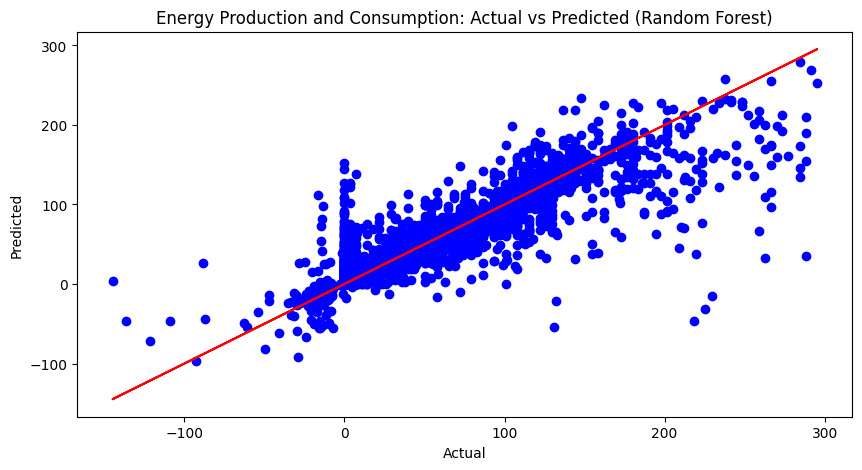


Results for energy produced and consumed every 15 minutes:
Loading energy data from cleaned900.csv...
Energy data loaded.
Using all 342103 rows of the data.
Training model...
Model trained in 48.86486053466797 seconds.
Mean Squared Error (Random Forest): 4264.779253989898


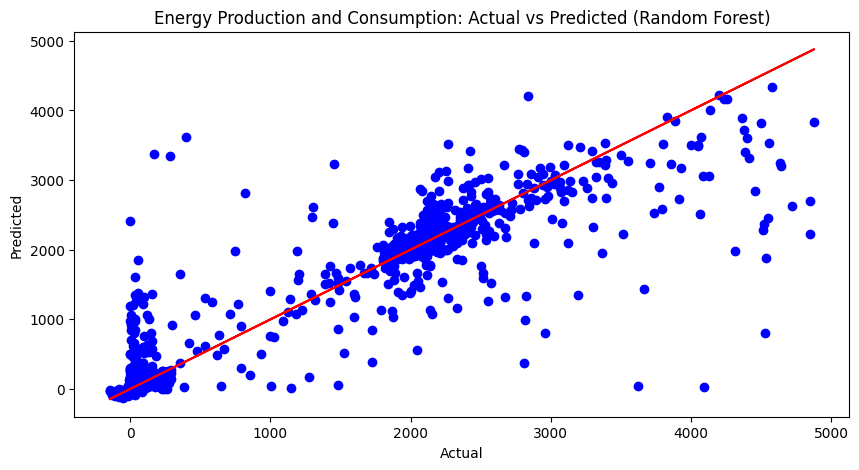

In [13]:
#Using random forest

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

def preprocess_data(data, is_energy_data=False):
    if is_energy_data:
        if 'VALUEDATE' in data.columns:
            data['VALUEDATE'] = pd.to_datetime(data['VALUEDATE'])
            data['Year'] = data['VALUEDATE'].dt.year
            data['Month'] = data['VALUEDATE'].dt.month
            data['Day'] = data['VALUEDATE'].dt.day
            data['Hour'] = data['VALUEDATE'].dt.hour
            data['Minute'] = data['VALUEDATE'].dt.minute
            data.drop(columns=['VALUEDATE'], inplace=True)
    return data

def train_and_evaluate(energy_data_file, energy_id_col, sample_size=None):
    try:
        # Load the energy data
        print(f"Loading energy data from {energy_data_file}...")
        energy_data = pd.read_csv(energy_data_file)
        energy_data = preprocess_data(energy_data, is_energy_data=True)
        print("Energy data loaded.")

        # Sample the data if sample_size is specified
        if sample_size:
            energy_data = energy_data.sample(n=sample_size, random_state=42)
            print(f"Data sampled. Using {sample_size} rows of the data.")
        else:
            sample_size = len(energy_data)
            print(f"Using all {sample_size} rows of the data.")

        # Features for prediction
        features = ['MESS_ID', 'Year', 'Month', 'Day', 'Hour', 'Minute']
        X = energy_data[features]
        y = energy_data['PVALUE']

        # Training and evaluation using Random Forest
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
        print("Training model...")
        start_time = time.time()
        model_rf.fit(X_train, y_train)
        print(f"Model trained in {time.time() - start_time} seconds.")
        y_pred_rf = model_rf.predict(X_test)
        mse_rf = mean_squared_error(y_test, y_pred_rf)
        print("Mean Squared Error (Random Forest):", mse_rf)

        # Plotting results
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test, y_pred_rf, color='blue')
        plt.plot(y_test, y_test, color='red')  # Diagonal line for reference
        plt.title('Energy Production and Consumption: Actual vs Predicted (Random Forest)')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()

    except Exception as e:
        print("An error occurred:", e)

# File paths for the two datasets
energy_data_minute = 'cleaned60.csv'
energy_data_15_minutes = 'cleaned900.csv'

# Column names to use for merging
energy_id_col = 'MESS_ID'

# Load the 15-minute-based dataset to determine sample size
print("Determining sample size from 15-minute-based dataset...")
fifteen_minute_data = pd.read_csv(energy_data_15_minutes)
fifteen_minute_data = preprocess_data(fifteen_minute_data, is_energy_data=True)
sample_size = len(fifteen_minute_data)
print(f"Sample size determined: {sample_size} rows.")

print("\nResults for energy produced and consumed every minute:")
train_and_evaluate(energy_data_minute, energy_id_col, sample_size=sample_size)  # Using the same sample size as the 15-minute-based data

print("\nResults for energy produced and consumed every 15 minutes:")
train_and_evaluate(energy_data_15_minutes, energy_id_col, sample_size=None)  # Using all of the 15-minute-based data

